In [1]:
#numerics and vis
import math
import numpy as np
import pandas as pd
from scipy import stats
import altair as alt
import altair_saver
import sys
import subprocess

import ete3
from ete3 import Tree, TreeStyle, TextFace


root = "/data/tobiassonva/data/eukgen/"
sys.path.insert(0, root)
%cd {root}

from core_functions.microcosm_functions import color_tree, tree_analysis
from core_functions.altair_plots import plot_alignment, plot_cumsum_counts
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#disable altair max rows
alt.data_transformers.disable_max_rows()
#get default altair style'
%run ~/scripts/altair_style_config_default.py

#dont wrap text output from cells
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))






/vf/users/tobiassonva/data/eukgen


/tmp/ipykernel_3062575/1835589706.py:29: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
VALIDATE TQtree2 models

In [ ]:
import io

#read and split data table from IQtree
model_data_file = 'testing/IQtree_models/merged_output.txt'
with open(model_data_file, 'r') as infile:
    #models = [m.split('\n') for m in infile.read().split(';')]
    models = infile.read().split(';')

#loop over models adding observations of rank as index to the data
#data is already sorted
data = pd.DataFrame()
for model in models:
    new_data = pd.read_csv(io.StringIO(model), delim_whitespace=True)
    new_data.reset_index(inplace=True, names='rank')
    new_data['rank'] = [max(10-x, 0) for x in new_data['rank']]
    data = pd.concat([data,new_data])

data_models = pd.Series({model:data[data.Model == model]['rank'].sum()/len(models) for model in data.Model.unique()})
data_models.sort_values(ascending=False)[0:50]

In [ ]:
plot_data = pd.DataFrame(data_models)
plot_data.reset_index(inplace=True)
plot_data.columns = ['model', 'score']
plot_data.sort_values(by='score', ascending=False, inplace=True)
plot_data['name']= [l.split('+')[0] for l in plot_data.model]
plot_data.reset_index(inplace=True, drop=True)
display(plot_data[0:50])

In [ ]:
plot = alt.Chart(plot_data[0:30]).mark_bar().encode(
    x= alt.X('model:O', sort=None, axis=alt.Axis(labelAngle=-45)),
    color = alt.Color('name'),
    y= alt.Y('score'),
).interactive()
plot.width = 1200
plot

In [ ]:
#fix further discrepancies in eukprot species labelling not reachable from orgid

from ete3 import NCBITaxa


error_ids = [2985, 191814, 35133, 88547, 438412, 419944, 1104430, 63605, 35686, 299832, 36769, 91373, 186019, 37163, 446134, 5748, 265536, 3028, 195968, 5774, 2949, 81532, 5709, 947084, 12967]

error_lineages = NCBITaxa().get_lineage_translator(error_ids)

error_lineages

#flat_list = [ x for xs in xss for x in xs ]
error_dict = [x for xs in error_lineages.values() for x in xs]
error_dict = NCBITaxa().get_taxid_translator(error_dict)


errorDF = pd.DataFrame()

for error_id, lineage in error_lineages.items():

    try:
        error_class = [error_dict[c] for c in lineage if NCBITaxa().get_rank([c])[c] == 'class']
    except ValueError:
        error_class = ['none']
        
    if error_class == []:
        error_class = ['none']
        
    error_name = NCBITaxa().get_taxid_translator([error_id])[error_id]
    print(error_id, error_class, error_name)        
    classDF = pd.DataFrame({'species': error_name, 'superkingdom':'Eukaryota', 'class':error_class},index=[error_id])
    errorDF = pd.concat([errorDF, classDF])

errorDF.loc[63605]['class'] = 'Heterolobosea'
errorDF.loc[419944]['class'] = 'Picozoa'
errorDF.loc[438412]['class'] = 'Amoebozoa'


In [80]:
# plot separate faceted series of KDE estimations for categorical data 
def plot_KDE_per_category(data, 
                          kde_key, 
                          facet_key,
                          orientation='vertical', 
                          facet_width=40, 
                          total_height=500, 
                          title='Data', 
                          plot_range=None,
                          kernel_width = 0.1):

    # encode sample size in the facet labels
    plot_data = data.copy()
    group_sizes = plot_data.groupby(facet_key).size()
    replace_dict = group_sizes.index + ' (n=' + group_sizes.astype(str) + ')'
    plot_data[facet_key] = plot_data[facet_key].replace(replace_dict)
    
    plot_title = title
    
    if plot_range != None:
        kde_range = plot_range
    else:
        kde_range = [plot_data[kde_key].min(), plot_data[kde_key].max()]
        
    # faceted KDE vertical
    if orientation == 'horizontal':
    
        facet_width = facet_width
        facet_height = total_height
        
        # create violin plot
        violins =alt.Chart(plot_data).transform_density(
            kde_key,
            bandwidth = kernel_width,
            as_=[kde_key, 'density'],
            extent=kde_range,
            groupby=[facet_key]

        ).mark_area(orient='horizontal').encode(
            y=alt.Y(kde_key+':Q'),
            color=alt.Color(facet_key+':N', legend=None),
            x=alt.X('density:Q', impute=None, title=None,
                    axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)),
            tooltip=alt.Tooltip([facet_key])
        )
        
        # create whisker plot
        whiskers =alt.Chart(plot_data).mark_boxplot(size=5, 
                                                    extent=1, 
                                                    outliers=False, 
                                                    ticks={'size':5}).encode(
                y=alt.Y(kde_key+':Q'),
                x=alt.value(facet_width),
                color=alt.value(colorlib['warmgrays'][8])
            )

        # stack and facet with configuration
        layer_chart = alt.layer(violins, whiskers).properties(
                                width=facet_width, 
                                height = facet_height).facet(
                                column=alt.Column(facet_key+':N', title=None, 
                                header=alt.Header(labelAngle=45,
                                                  labelFontSize=12,
                                                  labelPadding = -10,
                                                  labelOrient='bottom'))
        ).configure_facet(spacing=10).configure_view(stroke=None).properties(title = plot_title)

        return layer_chart
    
    # faceted KDE horizontal
    else:
        
        facet_height = facet_width
        facet_width = total_height
        
        # create violin plot
        violins =alt.Chart(plot_data).transform_density(
            kde_key,
            bandwidth = kernel_width,
            as_=[kde_key, 'density'],
            extent=kde_range,
            groupby=[facet_key]

        ).mark_area(orient='vertical').encode(
            x=alt.X(kde_key+':Q'),
            color=alt.Color(facet_key+':N', legend=None),
            y=alt.Y('density:Q', impute=None, title=None,
                    axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)),
            tooltip=alt.Tooltip([facet_key])
        )

        # create whisker plot
        whiskers =alt.Chart(plot_data).mark_boxplot(size=5, 
                                                    extent=1, 
                                                    outliers=False, 
                                                    ticks={'size':5}).encode(
                x=alt.X(kde_key+':Q'),
                y=alt.value(0),
                color=alt.value(colorlib['warmgrays'][8])
            )

        # stack and facet with configuration
        layer_chart = alt.layer(violins, whiskers).properties(
                                width=facet_width, 
                                height = facet_height).facet(
                                row=alt.Row(facet_key+':N', title=None, 
                                header=alt.Header(labelAngle=0,
                                                  labelFontSize=12,
                                                  labelAlign = 'left'))
        ).configure_facet(spacing=10).configure_view(stroke=None).properties(title = plot_title)

        return layer_chart

---- Temporary ----

In [ ]:
#check wellnes of fit of inverse gamma distribution for tree subset
treefiles = subprocess.run(f"find processing/microcosm2/ -name '*.treefile'",shell=True, text=True, capture_output=True)
treefiles = [f for f in treefiles.stdout.split('\n')][:-1]

In [ ]:
#check wellnes of fit of inverse gamma distribution for tree subset
for file in treefiles:

    #test invgamma
    treefile = file
    print(file)
    tree = Tree(treefile)
    p_high = 0.99
    p_low = 0

    outlier_nodes, dist_series, fitting_params, cutoffs = get_outlier_nodes_by_invgamma(tree, p_low, p_high)
    print(fitting_params)

    x_max = cutoffs[0] + 0.2

    #tree data
    dist_data = pd.DataFrame(dist_series)
    dist_data.columns = ['stem_length']

    #probability density values from fit
    x = np.linspace(stats.invgamma.pdf(0.01, fitting_params[0], fitting_params[1], fitting_params[2]),
                    stats.invgamma.pdf(0.99, fitting_params[0], fitting_params[1], fitting_params[2]), 1000)
    x = np.linspace(0.01, x_max, 1000)

    y = stats.invgamma.pdf(x, fitting_params[0], fitting_params[1], fitting_params[2])

    fit_data = pd.DataFrame({'stem_length':x, 'prob_density':y})
    fit_data = fit_data[fit_data.stem_length < x_max]

    #simulated data
    sim_data = stats.invgamma.rvs(fitting_params[0], fitting_params[1], fitting_params[2], size=len(tree))
    sim_data = pd.DataFrame(pd.Series(sim_data))
    sim_data.columns = ['stem_length']


    #plot cumsum hist
    plot, data = plot_cumsum_counts(dist_data.stem_length, title='experimental')
    plot, fit = plot_cumsum_counts(sim_data.stem_length, title='simulated from fit')

    merged = pd.concat([data, fit])

    cum_plot, merged_data = plot_cumsum_counts(merged, plot_type='default', formatted_data=True,
                                          x_min = 0, x_max=5, x_scale_type='linear', y_scale_type='linear')

    ks_test = stats.ks_2samp(dist_data.stem_length, fit_data.stem_length, alternative='two-sided', mode='auto')
    cum_plot.title = alt.TitleParams(f'p={ks_test.pvalue}, statistic={ks_test.statistic} ', fontSize=12)


    #data_hist with line fit
    title = alt.TitleParams(f"{treefile.split('/')[-1]}, {len(tree)} leaves, 99% CDF {cutoff_high}", fontSize=12)
    data_hist = alt.Chart(dist_data, title = title).mark_bar().encode(
        x= alt.X('stem_length', bin=alt.Bin(extent=[0, x_max], step=0.02)),
        y= alt.Y('count()')

    )


    fit_curve = alt.Chart(fit_data).mark_line(color='red').encode(
        x= alt.X('stem_length', scale=alt.Scale(domain=[0, x_max])),
        y= alt.Y('prob_density')

    )

    plot = alt.layer(data_hist, fit_curve).resolve_scale(y='independent')
    merge_plot = plot | cum_plot
    
    altair_saver.save(merge_plot, treefile+'.html' )

    subprocess.run(f'cp {treefile} /home/tobiassonva/data/eukgen/testing/invgamma_fitting/'.split())
    subprocess.run(f'mv {treefile}.html /home/tobiassonva/data/eukgen/testing/invgamma_fitting/'.split())
    
    print()

In [ ]:
#check wellnes of fit of lognorm distribution for tree subset
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#test lognorm
#treefile = treefiles[27]
tree = Tree(treefile)
p_high = 0.99
p_low = 0.0

outlier_nodes, dist_series, fitting_params = get_outlier_nodes_by_lognorm(tree, p_low, p_high)
print(fitting_params)

x_max = fitting_params[4] + 0.2

#tree data
dist_data = pd.DataFrame(dist_series)
dist_data.columns = ['stem_length']

#probability density values from fit
x = np.linspace(stats.lognorm.pdf(0.01, fitting_params[0], fitting_params[1], fitting_params[2]),
                stats.lognorm.pdf(0.99, fitting_params[0], fitting_params[1], fitting_params[2]), 1000)
x = np.linspace(0.01, x_max, 1000)

y = stats.lognorm.pdf(x, fitting_params[0], fitting_params[1], fitting_params[2])

fit_data = pd.DataFrame({'stem_length':x, 'prob_density':y})
fit_data = fit_data[fit_data.stem_length < x_max]

#simulated data
sim_data = stats.lognorm.rvs(fitting_params[0], fitting_params[1], fitting_params[2], size=len(tree))
sim_data = pd.DataFrame(pd.Series(sim_data))
sim_data.columns = ['stem_length']


#plot cumsum hist
plot, data = plot_cumsum_counts(dist_data.stem_length, title='experimental')
plot, fit = plot_cumsum_counts(sim_data.stem_length, title='simulated from fit')

merged = pd.concat([data, fit])

cum_plot, merged_data = plot_cumsum_counts(merged, plot_type='default', formatted_data=True,
                                      x_min = 0, x_max=5, x_scale_type='linear', y_scale_type='linear')

ks_test = stats.ks_2samp(dist_data.stem_length, fit_data.stem_length, alternative='two-sided', mode='auto')
cum_plot.title = alt.TitleParams(f'p={ks_test.pvalue}, statistic={ks_test.statistic} ', fontSize=12)


#data_hist with line fits
title = alt.TitleParams(f"{treefile.split('/')[-1]}, {len(tree)} leaves, 99% CDF {fitting_params[4]}", fontSize=12)
data_hist = alt.Chart(dist_data, title = title).mark_bar().encode(
    x= alt.X('stem_length', bin=alt.Bin(extent=[0, x_max], step=0.02)),
    y= alt.Y('count()')

)


fit_curve = alt.Chart(fit_data).mark_line(color='red').encode(
    x= alt.X('stem_length', scale=alt.Scale(domain=[0, x_max])),
    y= alt.Y('prob_density')

)

plot = alt.layer(data_hist, fit_curve).resolve_scale(y='independent')
merge_plot = plot | cum_plot
merge_plot



In [ ]:
CDD_annot = pd.read_csv('processing/euk72_ep3/euk72_ep_hhm.CDD_annotation.tsv', sep='\t', index_col=0)
CDD_annot['score'] = CDD_annot.Prob*CDD_annot.Pairwise_cov
CDD_annot.sort_values(by='score', inplace=True, ascending=False)

In [2]:
# load KEGG search data
# note the swapped labels from HHsuite 
KEGG_annot = pd.read_csv('processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv', sep='\t')
#filter self hits
KEGG_annot = KEGG_annot[KEGG_annot.Query != KEGG_annot.Target]

# rename profiles to merge euk and prok versions of profiles
KEGG_annot['Target'] = [name.split('_')[0] for name in KEGG_annot['Target']]

# transfer annotation from KEGG skipping duplicate entries
KEGG_names = pd.read_csv('/data/tobiassonva/data/databases/kegg/kog_functions.tsv', sep='\t')
KEGG_names.set_index('KOGID', inplace=True)
KEGG_annot['Description'] = KEGG_names[~(KEGG_names.index.duplicated())].loc[KEGG_annot.Target].FUNCTION.values

# KEGG pathway mapping
KEGG_map = pd.read_csv('/data/tobiassonva/data/databases/kegg/kegg_category_mapping.tsv', sep='\t', index_col=0)

# sort and index
KEGG_annot.sort_values(by='Score', inplace=True, ascending=False)
KEGG_annot.set_index('Query', inplace=True)




In [3]:
# EUK CLUSTER DATA
euk_cluster = pd.read_csv('processing/euk72_ep/euk72_ep.repseq.cascaded_cluster.tsv', 
                          sep= '\t', names=['cluster_acc', 'acc'], index_col=0)

In [4]:
# EUK TAX DATA
taxDF = pd.read_csv('/data/tobiassonva/data/eukgen/core_data/taxonomy/euk_prok_merged_protein_revised.tax',
                    sep='\t', names=['acc', 'orgid', 'superkingdom', 'class'], index_col=0)

In [5]:
# LOCALISATION DATA
loc_annot = pd.read_csv('/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.protatlas_annotation.tsv', sep='\t', index_col=0)

In [70]:
# merge all tree_data.csv files and clade_data.csv

microcosm_root = 'processing/microcosm/'

treefiles = subprocess.run(f"find {microcosm_root} -maxdepth 2 -name '*.merged.tree_data.tsvedited'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    data = pd.read_csv(file, sep='\t', index_col=0)
    new_data.append(data)

all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data.tsv', sep='\t')

27336


In [6]:
tree_data = pd.read_csv('microcosm_tree_data.tsv.edited', sep='\t', index_col=0)
#tree_data.set_index('tree_name', inplace=True)

/tmp/ipykernel_3062575/3798548228.py:1: DtypeWarning: Columns (4,11) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_data = pd.read_csv('microcosm_tree_data.tsv.edited', sep='\t', index_col=0)


In [ ]:
# merge all leaf_data for clade mapping
new_data = []
for microcosm in tree_data.index.unique():
    
    leaffile = f'{microcosm_root}/{microcosm}/{microcosm}.merged.fasta.leaf_mapping'
    
    try:
        data = pd.read_csv(leaffile, sep='\t', names = ['acc', 'leaf', 'superkingdom', 'class'])
        data['tree_name'] = [microcosm for _ in data.index]
        new_data.append(data.set_index('tree_name'))
        
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data.leaf_mapping.tsv', sep='\t')

In [ ]:
leaf_data = pd.read_csv('microcosm_tree_data.leaf_mapping.tsv', sep='\t', index_col=0)

In [ ]:
leaf_data_euk = leaf_data[leaf_data.superkingdom == 'Eukaryota']

In [ ]:
# merge all tree_data.csv files and clade_data.csv

treefiles = subprocess.run(f"find /data/luojaa/eukgen/processing/microcosm_enriched/ -maxdepth 2  -name '*.tree_data.tsv'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    try:
        data = pd.read_csv(file, sep='\t', index_col=0)
        new_data.append(data)
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data_jac_enriched.tsv', sep='\t')

In [ ]:
# merge all tree_data.csv files and clade_data.csv

treefiles = subprocess.run(f"find /data/luojaa/eukgen/processing/microcosm/ -maxdepth 2 -name '*.tree_data.tsv'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    try:
        data = pd.read_csv(file, sep='\t', index_col=0)
        new_data.append(data)
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data_jac.tsv', sep='\t')

In [ ]:
tree_data = pd.read_csv('tmp/microcosm_tree_data_jac_enriched.tsv', sep='\t', index_col=0)
tree_data.set_index('tree_name', inplace=True)

In [ ]:
tree_data2 = pd.read_csv('tmp/microcosm_tree_data_jac_enriched2_test2.tsv', sep='\t', index_col=0)
tree_data2.set_index('tree_name', inplace=True)

In [ ]:
# find and merge leafDFs from tree_mapping
# leaves can be present on multiple trees so index is per tree

microcosm_root = '/data/luojaa/eukgen/processing/garbage/microcosm_enriched2.1/'

new_data = []
for microcosm in tree_data2.index.unique():
    
    leaffile = f'{microcosm_root}/{microcosm}/{microcosm}.merged.fasta.leaf_mapping'
    
    
    try:
        data = pd.read_csv(leaffile, sep='\t', names = ['acc', 'leaf', 'superkingdom', 'class'])
        data['tree_name'] = [microcosm for _ in data.index]
        new_data.append(data.set_index('tree_name'))
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data_jac_enriched.leaf_mapping.tsv', sep='\t')

In [ ]:
leaf_data = pd.read_csv('tmp/microcosm_tree_data_jac_enriched.leaf_mapping.tsv', sep='\t', index_col=None)
leaf_data.set_index('acc', inplace=True)

In [ ]:
# plot overall branch length distribution of most likley sister taxa based on c-ELW

tree_data = tree_data.sort_values(by='c-ELW', ascending=False)

filtered_data = tree_data[(tree_data.stem_length.between(0.00, 2)) &
                          (tree_data['c-ELW'] > 0.8)] #& 
#                           (tree_data.prok_clade_weight >= 0.6)]# & 
                          #~(tree_data.euk_clade_rep.duplicated())]

a = filtered_data[~(filtered_data.stem_length.duplicated())]

#a['dist'] = [np.log(stem) for stem in a['dist']]

#taxa = a.prok_taxa.value_counts().index[0:20].values
taxa = ['Cyanobacteriota', 'Asgard', 'Alphaproteobacteria', 'Actinomycetota']
#taxa = ['Aquificae']

a = a[a.prok_taxa.isin(taxa)]

title = f'Eukaryotic branch length per taxa, Sample_size:{a.shape[0]}'
#title = f'{a.shape[0]}'
#title = f'{len(a)} normalized stem lengths as per Gabaldon 2016'

KDE = alt.Chart(a, title=alt.TitleParams(text=title, fontSize=12)).mark_area(line=True, opacity=0.2).transform_density(
    'stem_length',
    as_=['stem_length', 'density'],
    bandwidth=0.05,
    groupby = ['prok_taxa']
    
    ).encode(
    x=alt.X('stem_length:Q', scale=alt.Scale(domain=[0,2], clamp=True, )),
    y=alt.Y('density:Q', scale=alt.Scale(domain=[0,3], clamp=False)),
    color=alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])

).interactive()

bar = alt.Chart(a, title=title).transform_joinaggregate(
    total='count(*)',
    groupby=['prok_taxa']
    ).transform_calculate(
    pct='1 / datum.total'
    ).mark_bar().encode(
    x=alt.X('stem_length:Q', bin=alt.Bin(step=0.05), scale=alt.Scale(domain=[0,4], clamp=True)),
    y=alt.Y('sum(pct):Q', scale=alt.Scale(domain=[0,0.4])),
    color=alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])

).interactive()
KDE

In [ ]:
#format all taxa specific closest sisters
for taxa in sorted(filtered_data.prok_taxa.unique()):
    print(taxa)
    tree_data_taxa = filtered_data[filtered_data.prok_taxa == taxa]
    
    CDD_hits = CDD_annot_filtered.loc[tree_data_taxa.index]
    
    CDD_good = CDD_hits[CDD_hits['score']>70].sort_values(by='score', ascending=False)
    CDD_good = CDD_good[~(CDD_good.index.duplicated())]
    CDD_good['closest_sister_taxa'] = [taxa]*CDD_good.shape[0]
    
    data[taxa] = CDD_good.round(2)

#write to file
all_data = pd.concat(data.values())

all_data.to_csv('tmp/microcosm_data_CDD.tsv', sep='\t')
    
#write to multi-sheet excel
xlsx_file = 'test2.xlsx'
with pd.ExcelWriter(xlsx_file) as writer:
    for taxa, df in data.items():
        df.to_excel(writer, taxa)

In [ ]:
# plot clade analysis confidence distribution for tests 

from core_functions.altair_plots import plot_cumsum_counts

plot_data = tree_data[tree_data.deltaL != -1]

print(plot_data.index.unique().shape)

tests = ['c-ELW','bp-RELL', 'p-KH', 'p-SH', 'p-AU']
all_data_dict = {}

for test in tests:
    
    plot_data[test] = plot_data[test].astype(float)
    
    print(test)
    plot_data = plot_data.sort_values(by=[test])

    filtered_data = plot_data[(plot_data[test+'_accept'] == '+')]
    best_data = filtered_data.groupby('euk_clade_rep').apply(lambda data: data[test].max())

    
    plot, data1 = plot_cumsum_counts(plot_data[test], title=test+' all')
    plot, data2 = plot_cumsum_counts(filtered_data[test], title=test+' 95% confidence set')
    plot, data3 = plot_cumsum_counts(best_data, title=test+ ' maximum')
    
    
    all_data = pd.concat([data3,data1,data2])
    
    plot, data = plot_cumsum_counts(all_data, formatted_data=True, plot_type='default', 
                                x_scale_type='linear', y_scale_type='linear', 
                               x_min=0, x_max=1, title='Confidence distributions '+test, x_label='probability')
    
    display(plot)
    
    all_data_dict['all_'+test] = data1
    all_data_dict['best_'+test] = data2

In [21]:
# plot changes in cELW contributions across euk_clade_scopes

all_data = []
for i in range(1,25):

    system_data = tree_data[(tree_data.euk_scope_len > i)
                            & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))]

    tax_data = system_data[['prok_taxa', 'c-ELW']]
    tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum().sort_values(by='c-ELW', ascending=False).round(2))
    tax_data.columns=[i]
    all_data.append((tax_data/tax_data.sum()).round(3))

plot_data = pd.concat(all_data, axis = 1).fillna(0).reset_index()

plot_data

plot_data = plot_data.melt(id_vars='prok_taxa', value_vars=plot_data.columns)

plot_tags = ['Actinomycetota', 'Gammaproteobacteria', 'Asgard', 'Bacillota', 'Alphaproteobacteria', 'FCB group', 'PVC group',
            'Cyanobacteriota', 'Euryarchaeota', 'TACK group']

plot_data = plot_data[(plot_data.variable > -1) & (plot_data.prok_taxa.isin(plot_tags))]


alt.Chart(plot_data, title='Total cELW').mark_line(strokeWidth=2).encode(
    x=alt.X('variable'),
    y=alt.Y('value'),
    color = alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])
).interactive()

alt.Chart(...)

In [611]:
tree_data

euk_clade_rep  euk_clade_size  euk_clade_weight euk_leaf_clade  \
tree_name                                                                      
AFC39997.1      YP_874536.1             6.0          0.545455          False   
AFR24247.1   EP00929P060973             5.0          0.294118          False   
AFR24247.1   EP00929P060973             5.0          0.294118          False   
AFR24247.1   EP00929P060973             5.0          0.294118          False   
AFR24247.1   EP00929P060973             5.0          0.294118          False   
...                     ...             ...               ...            ...   
YP_277393.1      AOM66993.1            10.0          0.312500          False   
YP_874495.1  EP00229P009105            11.0          1.000000          False   
YP_874495.1  EP00229P009105            11.0          1.000000          False   
YP_874557.1  EP00918P099689             5.0          0.384615          False   
YP_874557.1      CAT18861.1            13.0          0.500000          False   

                    euk_LCA  \
tree_name                     
AFC39997.1   Diaphoretickes   
AFR24247.1      Dinophyceae   
AFR24247.1      Dinophyceae   
AFR24247.1      Dinophyceae   
AFR24247.1      Dinophyceae   
...                     ...   
YP_277393.1  Diaphoretickes   
YP_874495.1  Diaphoretickes   
YP_874495.1  Diaphoretickes   
YP_874557.1  Diaphoretickes   
YP_874557.1  Diaphoretickes   

                                                     euk_scope  euk_scope_len  \
tree_name                                                                       
AFC39997.1                               Ochrophyta|Rhodophyta            2.0   
AFR24247.1                                         Dinophyceae            1.0   
AFR24247.1                                         Dinophyceae            1.0   
AFR24247.1                                         Dinophyceae            1.0   
AFR24247.1                                         Dinophyceae            1.0   
...                                                        ...            ...   
YP_277393.1                              Rhodophyta|Ochrophyta            2.0   
YP_874495.1                             Ochrophyta|Chlorophyta            2.0   
YP_874495.1                             Ochrophyta|Chlorophyta            2.0   
YP_874557.1  Dinophyceae|Chlorophyta|Haptista|Apicomplexa|S...            5.0   
YP_874557.1                                Ochrophyta|Haptista            2.0   

             prok_clade_rep  prok_clade_size  prok_clade_weight  ...   p-KH  \
tree_name                                                        ...          
AFC39997.1   WP_015079326_1             93.0           1.000000  ...  1.000   
AFR24247.1   WP_058261992_1              3.0           0.428571  ...  0.000   
AFR24247.1   WP_052721353_1              7.0           0.194444  ...  0.000   
AFR24247.1   WP_126703635_1              3.0           0.750000  ...  0.000   
AFR24247.1   WP_174672495_1              3.0           0.250000  ...  0.967   
...                     ...              ...                ...  ...    ...   
YP_277393.1  WP_053378484_1              6.0           0.400000  ...  0.187   
YP_874495.1  WP_062244170_1              3.0           0.600000  ...  0.500   
YP_874495.1  WP_104907463_1             14.0           0.736842  ...  0.500   
YP_874557.1  WP_094328215_1            100.0           1.000000  ...  1.000   
YP_874557.1  WP_094328215_1            100.0           1.000000  ...  1.000   

            p-KH_accept    p-SH  p-SH_accept         c-ELW  c-ELW_accept  \
tree_name                                                                  
AFC39997.1            +  1.0000            +  1.000000e+00             +   
AFR24247.1            -  0.0000            -  6.420000e-41             -   
AFR24247.1            -  0.0002            -  6.880000e-16             -   
AFR24247.1            -  0.0040            -  2.070000e-09             -   
AFR24247.1            +  1.0000

In [125]:
all_maps = KEGG_map[KEGG_map.category_id.str.startswith('map')].category_id.unique()



plot_tags = ['Actinomycetota', 'Gammaproteobacteria', 'Asgard', 'Bacillota', 'Alphaproteobacteria', 'FCB group', 'PVC group',
            'Cyanobacteriota', 'Euryarchaeota', 'TACK group']

plot_tags = ['Actinomycetota',  'Asgard', 'Alphaproteobacteria',
            'Cyanobacteriota', 'Euryarchaeota', 'TACK group']


# sample interesting taxa with reasonable lengths
plot_data = tree_data[(tree_data.stem_length.between(0, 4)) 
                      & (tree_data.prok_taxa.isin(plot_tags))
                          & (tree_data['c-ELW'].between(0.7, 1))
                      & (tree_data.euk_leaf_clade == False)
                      & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (tree_data.euk_scope_len > 5)
                      #& (tree_data.index.isin(mics_with_cogs))
                      #& (tree_data.prok_taxa == 'Asgard')
                      ]

plot_data = plot_data.sort_values(by='c-ELW', ascending=False).drop_duplicates(subset='euk_clade_rep', keep='first')

print(plot_data.shape)
plot_data['manual_taxa'] = ['Other Bacteria' for taxa in plot_data['prok_taxa']]
plot_data.loc[plot_data.prok_taxa.isin(['Asgard','TACK group', 'Euryarchaeota']), 'manual_taxa'] = 'Archaea'
plot_data.loc[plot_data.prok_taxa == 'Alphaproteobacteria', 'manual_taxa'] = 'Alphaproteobacteria'
#plot_data['manual_taxa'] = ['Alphaproteobacteria' if taxa == 'Alphaproteobacteria' and else 'Other Bacteria' ]


(3136, 29)


In [126]:
plot_data['map'] = ['other' for _ in plot_data.index]

translation = ['map03010', 'map00970', 'map03013', 'map03015', 'map03008']
information_processing = ['map03020, map03022', 'map03040', 'map03030', 'map03410', 'map03420', 'map03430', 'map03440', 'map03450']
metabolism = ['map00010','map00020','map00030','map00040','map00051']
mitochondrial_metabolism = ['map00190', 'map00680', 'map00910']

for map_n in [information_processing, translation, metabolism, mitochondrial_metabolism]:

    print(map_n)
    # assign information processing
    KOGS = KEGG_map[KEGG_map.category_id.isin(map_n)].index.unique()
    
    print(len(KOGS))
    
    mics_with_cogs = KEGG_annot_top[KEGG_annot_top.Target.isin(KOGS)].index.unique()
    mics_with_cogs = list(set(mics_with_cogs).intersection(plot_data.index))
    
    if len(mics_with_cogs) > 0:
        map_name =  KEGG_map[KEGG_map.category_id.isin(map_n)].category_name[0]
        plot_data.loc[mics_with_cogs, 'map'] = map_name
        print(f'Added {map_name} with {len(mics_with_cogs)}')

['map03020, map03022', 'map03040', 'map03030', 'map03410', 'map03420', 'map03430', 'map03440', 'map03450']
341
Added Homologous recombination with 49
['map03010', 'map00970', 'map03013', 'map03015', 'map03008']
421
Added Ribosome with 99
['map00010', 'map00020', 'map00030', 'map00040', 'map00051']
390
Added Fructose and mannose metabolism with 80
['map00190', 'map00680', 'map00910']
484
Added Methane metabolism with 81


In [127]:
# faceted KDE vertical
plot_title = ''#'Stem length distributions for Eukaryotic clades (KDE_kernel = 0.1)'

# axis key for KDE
kde_key = 'stem_length'

# KDE range
kde_range = [0, 2]

# facet key
facet_key = 'map'
facet_width = 60
total_height = 300
kernel = 0.1


plot1 =  plot_KDE_per_category(plot_data, 
                          kde_key, 
                          facet_key,
                          orientation='vertical', 
                          facet_width=facet_width, 
                          total_height=total_height, 
                          title=plot_title, 
                          plot_range=kde_range,
                        kernel_width=kernel)


plot2 =  plot_KDE_per_category(plot_data, 
                          kde_key, 
                          facet_key,
                          orientation='horizontal', 
                          facet_width=facet_width, 
                          total_height=total_height, 
                          title=plot_title, 
                          plot_range=kde_range,
                              kernel_width=kernel)

display(plot1, plot2)

alt.FacetChart(...)

alt.FacetChart(...)

In [8]:
a = iter(tree_data.groupby('euk_clade_rep'))

In [258]:
all_data = tree_data.drop_duplicates('euk_clade_rep').euk_scope_len

In [12]:
universal_i = tree_data[(tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms'])) 
                        & (tree_data.euk_scope_len > 0)].index.unique()
KEGG_i = KEGG_annot.index.unique()


In [15]:
print(KEGG_annot_top.loc[list(set(universal_i).intersection(KEGG_i))].shape)
print(*KEGG_annot_top.loc[list(set(universal_i).intersection(KEGG_i))].Description.value_counts()[0:50].index, sep='\n')


(20742, 18)
uncharacterized protein
26S proteasome non-ATPase regulatory subunit 10
pentatricopeptide repeat domain-containing protein 1
type IV pilus assembly protein PilF
phytanoyl-CoA hydroxylase [EC:1.14.11.18]
Ran GTPase-activating protein 1
COMPASS component SWD3
arsenite methyltransferase [EC:2.1.1.137]
3-oxoadipate enol-lactonase [EC:3.1.1.24]
2-O-methyltransferase [EC:2.1.1.-]
putative transposase
leucine-rich repeat protein SHOC2
prolyl 4-hydroxylase [EC:1.14.11.2]
calmodulin
Rab9 effector protein with kelch motifs
phosphoserine phosphatase [EC:3.1.3.3]
sterile alpha motif and leucine zipper containing kinase AZK [EC:2.7.11.25]
regulator of chromosome condensation
F-box and leucine-rich repeat protein 2/20
acyl-CoA thioesterase I [EC:3.1.2.- 3.1.2.2 3.1.1.2 3.1.1.5]
MFS transporter, DHA1 family, tetracycline resistance protein
magnesium transporter
radial spoke head protein 1
serine/threonine-protein phosphatase 6 regulatory ankyrin repeat subunit A
isoamyl acetate esterase [

In [15]:
tree_data = tree_data_raw

In [7]:
KEGG_annot_top = KEGG_annot.sort_values(by='Score').reset_index().drop_duplicates(subset='Query', keep='last').set_index('Query')

In [525]:
#koglist =['K03236','K03113','K03237','K03238','K03242','K15026','K03239','K03754','K03241','K03680','K03240','K15027','K03262','K03263','K03243','K03264','K03254','K03253','K03252','K03251','K03250','K03249','K03248','K03247','K03246','K03245','K15028','K15029','K15030','K03257','K13025','K03258','K03259','K03260','K24086','K03261']
KOGS = KEGG_map[KEGG_map.category_id.isin(information_processing_and_translation)].index.unique()
#KOGS = KEGG_map[KEGG_map.category_name.str.contains('M00168')].index.unique()

#KOGS = KEGG_names[KEGG_names.FUNCTION.str.contains('ATP-binding cassette, subfamily B')].index.unique()
#KOGS = ['K04794']

mics_with_cogs = KEGG_annot_top[KEGG_annot_top.Target.isin(KOGS)].index.unique()
#mics_with_cogs = KEGG_annot[KEGG_annot.Target.isin(KOGS)].index.unique()

system_data = tree_data[(tree_data['c-ELW'].between(0.5,1)) & (tree_data.index.isin(mics_with_cogs))]
#system_data = tree_data[(tree_data['c-ELW'] > 0.7) & (tree_data.index.isin(mics_with_cogs))]
#system_data = tree_data[(tree_data['c-ELW'].between(0.5, 0.999)) & (tree_data.prok_taxa == 'Gammaproteobacteria') & (tree_data.index.isin(mics_with_cogs))]
#system_data = tree_data[(tree_data['c-ELW'].between(0.7, 0.999)) & (tree_data.prok_taxa == 'Chlamydiia')]
                        
print(KEGG_names.loc[KOGS])
print(len(KOGS))

print(len(mics_with_cogs))
print(len(system_data.index.unique()))

systems = iter(system_data.sort_values(by='c-ELW', ascending=False).index.unique())

KeyError: "['K14576', 'K14238', 'K14239', 'K14229', 'K01977', 'K26477', 'K14228', 'K14276', 'K14277', 'K14279', 'K14278', 'K14483', 'K14280', 'K14232', 'K14226', 'K01986', 'K01979', 'K14227', 'K14233', 'K14225', 'K14231', 'K14219', 'K01985', 'K14218', 'K14230', 'K14224', 'K14220', 'K14234', 'K01981', 'K01980', 'K14235', 'K14221', 'K14237', 'K14223', 'K01982', 'K14222', 'K14236'] not in index"

In [282]:
tax_data = system_data[['prok_taxa', 'c-ELW']]
print(tax_data.index.unique().shape)
tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum().sort_values(by='c-ELW', ascending=False).round(2))
display((tax_data/tax_data.sum()).round(3))

(16963,)


c-ELW
prok_taxa                     
Actinomycetota           0.168
Gammaproteobacteria      0.126
Asgard                   0.116
Bacillota                0.106
Alphaproteobacteria      0.088
FCB group                0.077
PVC group                0.047
Cyanobacteriota          0.045
Euryarchaeota            0.042
Betaproteobacteria       0.039
DELETE                   0.037
Myxococcota              0.023
TACK group               0.022
Thermodesulfobacteriota  0.017
Campylobacterota         0.012
Mycoplasmatota           0.008
Acidobacteriota          0.006
Chloroflexota            0.006
Thermoplasmata           0.004
Chlamydiia               0.004
Thermotogae              0.003
Deltaproteobacteria      0.002
Bdellovibrionota         0.001
DPANN group              0.000

In [71]:
# sample interesting taxa with reasonable lengths
sample_i = tree_data[
                      #& (tree_data.prok_taxa.isin(plot_tags))
                       (tree_data['c-ELW'].between(0.7, 0.9999))
                      #& (tree_data.euk_leaf_clade == False)
                      & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (tree_data.euk_scope_len > 15)
                      #& (tree_data.index.isin(mics_with_cogs))
                      & (tree_data.prok_taxa == 'Actinomycetota')
                      ].index.unique()

In [72]:
systems = iter(sample_i)
print(sample_i.shape)

(44,)


In [77]:
shared_sample_i = list(set(sample_i).intersection(KEGG_annot_top.index))
print(*KEGG_annot_top.loc[shared_sample_i, ['Description']].values, sep='\n')

['glycerol-3-phosphate dehydrogenase (NAD+) [EC:1.1.1.8]']
['D-alanine transaminase [EC:2.6.1.21]']
['Rab9 effector protein with kelch motifs']
['MFS transporter, Spinster family, sphingosine-1-phosphate transporter']
['DIS3-like exonuclease 2 [EC:3.1.13.-]']
['aarF domain-containing kinase']
['solute carrier family 35, member F1/2']
['adrenodoxin-NADP+ reductase [EC:1.18.1.6]']
['transducin (beta)-like 1']
['cytosolic nonspecific dipeptidase [EC:3.4.13.18]']
['long-chain-fatty-acid--CoA ligase ACSBG [EC:6.2.1.3]']
['septum site-determining protein MinD']
['thiamine-triphosphatase [EC:3.6.1.28]']
['non-canonical poly(A) RNA polymerase PAPD5/7 [EC:2.7.7.19]']
['mitogen-activated protein kinase organizer 1']
['mitogen-activated protein kinase 1/3 [EC:2.7.11.24]']
['phosphoglycerate kinase [EC:2.7.2.3]']
['IMP dehydrogenase [EC:1.1.1.205]']
['WD repeat-containing protein 61']
['nicotinamide mononucleotide adenylyltransferase [EC:2.7.7.1 2.7.7.18]']
['acylglycerol lipase [EC:3.1.1.23]']
['

EP00092P105052


Target        E-value   Prob  Score  Pairwise_cov  \
Query                                                               
EP00092P105052  K07936  9.000000e-125  100.0  794.9      0.953704   
EP00092P105052  K07976   1.400000e-44  100.0  298.6      0.807692   
EP00092P105052  K07889   2.500000e-43  100.0  295.4      0.830097   
EP00092P105052  K07881   5.300000e-42  100.0  290.2      0.775701   
EP00092P105052  K07901   5.000000e-42  100.0  286.9      0.879227   
EP00092P105052  K07876   9.000000e-42  100.0  286.7      0.812500   
EP00092P105052  K07880   3.300000e-41  100.0  285.2      0.774648   
EP00092P105052  K07890   5.700000e-41  100.0  283.6      0.775701   
EP00092P105052  K07918   6.100000e-41  100.0  283.3      0.779343   
EP00092P105052  K07897   4.400000e-41  100.0  282.9      0.879227   
EP00092P105052  K07910   3.100000e-40  100.0  278.1      0.820388   
EP00092P105052  K07877   7.700000e-40  100.0  276.6      0.787736   
EP00092P105052  K07916   1.100000e-39  100.0  273.8      0.822660   
EP00092P105052  K07930   2.100000e-38  100.0  267.5      0.783019   
EP00092P105052  K07903   1.100000e-38  100.0  267.2      0.807692   
EP00092P105052  K06234   2.500000e-37  100.0  263.6      0.738197   
EP00092P105052  K07893   6.800000e-38  100.0  263.5      0.795122   
EP00092P105052  K07917   2.000000e-37  100.0  259.7      0.807692   
EP00092P105052  K07899   3.500000e-37  100.0  258.0      0.805970   

                                    Description  
Query                                            
EP00092P105052  GTP-binding nuclear protein Ran  
EP00092P105052                Rab family, other  
EP00092P105052       Ras-related protein Rab-5C  
EP00092P105052       Ras-related protein Rab-14  
EP00092P105052       Ras-related protein Rab-8A  
EP00092P105052       Ras-related protein Rab-35  
EP00092P105052       Ras-related protein Rab-4B  
EP00092P105052       Ras-related protein Rab-21  
EP00092P105052       Ras-related protein Rab-32  
EP00092P105052       Ras-related protein Rab-7A  
EP00092P105052       Ras-related protein Rab-18  
EP00092P105052       Ras-related protein Rab-2A  
EP00092P105052      Ras-related protein Rab-7L1  
EP00092P105052       Ras-related protein Rab-43  
EP00092P105052       Ras-related protein Rab-10  
EP00092P105052       Ras-related protein Rab-23  
EP00092P105052       Ras-related protein Rab-6A  
EP00092P105052       Ras-related protein Rab-30  
EP00092P105052       Ras-related protein Rab-9A

System EP00092P105052 has Eukaryotic clades ['XP_005790694.1']
Tree has 100 leaves


euk_clade_rep    euk_LCA  euk_scope_len       prok_taxa  \
tree_name                                                                  
EP00092P105052  XP_005790694.1  Eukaryota           17.0          Asgard   
EP00092P105052  XP_005790694.1  Eukaryota           17.0   Euryarchaeota   
EP00092P105052  XP_005790694.1  Eukaryota           17.0          Asgard   
EP00092P105052  XP_005790694.1  Eukaryota           17.0          Asgard   
EP00092P105052  XP_005790694.1  Eukaryota           17.0  Actinomycetota   
EP00092P105052  XP_005790694.1  Eukaryota           17.0          Asgard   
EP00092P105052  XP_005790694.1  Eukaryota           17.0       Bacillota   

                    dist  stem_length  deltaL     c-ELW c-ELW_accept  \
tree_name                                                              
EP00092P105052  3.287361     3.665506   0.000  0.949000            +   
EP00092P105052  4.611448     4.911837  16.928  0.027500            +   
EP00092P105052  4.208389     3.336211  20.153  0.023900            -   
EP00092P105052  2.084366     0.870162  51.576  0.000014            -   
EP00092P105052  4.480347     3.336211  51.575  0.000014            -   
EP00092P105052  4.182658     3.336211  61.160  0.000002            -   
EP00092P105052  4.580929     4.911837  61.160  0.000002            -   

                    p-AU p-AU_accept  
tree_name                             
EP00092P105052  0.973000           +  
EP00092P105052  0.046300           -  
EP00092P105052  0.041800           -  
EP00092P105052  0.000435           -  
EP00092P105052  0.000434           -  
EP00092P105052  0.000003           -  
EP00092P105052  0.000006           -

alt.VConcatChart(...)

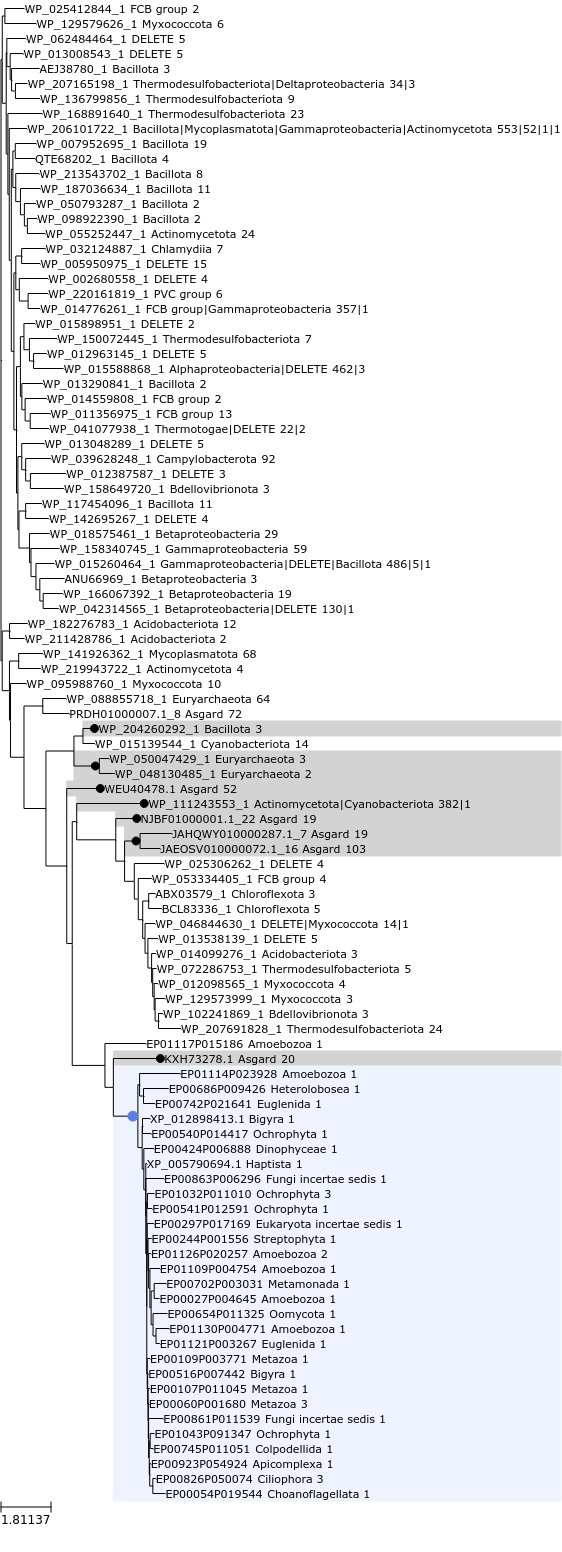

In [58]:
#microcosm_path = '/data/luojaa/eukgen/processing/microcosm_enriched/'
microcosm_path = '/data/tobiassonva/data/eukgen/processing/microcosm/'

#system = 'EP00923P035571'
system = next(systems)

data = tree_data

print(system)
try:
    #print(KEGG_names.loc[system])
    display(KEGG_annot.loc[system, ['Target', 'E-value', 'Prob', 'Score', 'Pairwise_cov', 'Description']])
except KeyError:
    print('??')
    
data = data.loc[[system]].sort_values(by='c-ELW', ascending=False)
    
clades = data.euk_clade_rep.unique()
print(f'System {system} has Eukaryotic clades {clades}')

tree = Tree(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
annot_tree, tree_img = color_tree(tree, view_in_notebook=True)


from core_functions.altair_plots import plot_alignment
aln_file = f'{microcosm_path}{system}/{system}.merged.fasta.muscle'

#leaf_names = [leaf.name for leaf in trees[system].get_leaves()]
leaf_names = [leaf.name for leaf in tree.get_leaves()]

plot, aln_data = plot_alignment(aln_file, seqlimit=100, plot_range=(0,300), label_order=leaf_names)

print(f'Tree has {len(leaf_names)} leaves')
display(data.iloc[:,[0,4,6,11,12,16,18,25,26,27,28]])
display(plot)

display(tree_img)

In [54]:
map_id = 'M00152'
elw_cutoff = 0.7

map_kogs = KEGG_map[KEGG_map.category_id.isin(['M00131'])].index

map_kogs = KOGS


print(map_id, KEGG_map[KEGG_map.category_id == map_id].iloc[0, 1])
print(map_kogs)
filter_data = tree_data[tree_data.index.isin(KEGG_annot[KEGG_annot.Target.isin(map_kogs)].index)]
systems = iter(set(filter_data[filter_data['c-ELW'] > elw_cutoff].index))

# best = []
# for tree, data in filter_data[filter_data['c-ELW_accept'].isin(['+', 'NONE'])].sort_values(by='c-ELW', ascending=False).groupby('euk_clade_rep'):
#     best.extend(data['prok_taxa'].values)
    
# all_accepted_sisters = pd.DataFrame([pd.Series(best).value_counts()[0:15],pd.Series(best).value_counts(normalize=True)[0:15]]).transpose()

best = []
for tree, data in filter_data[filter_data['c-ELW_accept'].isin(['+', 'NONE'])].sort_values(by='c-ELW', ascending=False).groupby('euk_clade_rep'):
    best.append(data.iloc[0]['prok_taxa'])
    
all_closest_sisters = pd.DataFrame([pd.Series(best).value_counts()[0:15],pd.Series(best).value_counts(normalize=True)[0:15]]).transpose()

best = []
for tree, data in filter_data[(filter_data['c-ELW_accept'] == '+') &
                            (filter_data['c-ELW'] > elw_cutoff)].sort_values(by='c-ELW', ascending=False).groupby('euk_clade_rep'):
    best.append(data.iloc[0]['prok_taxa'])
    

all_significant_closest_sisters = pd.DataFrame([pd.Series(best).value_counts(),pd.Series(best).value_counts(normalize=True)]).transpose()[0:50]


# display(all_accepted_sisters)
display(all_closest_sisters)
display(all_significant_closest_sisters)

NameError: name 'KOGS' is not defined

In [ ]:
KEGG_map_filtered = KEGG_map[KEGG_map.category_id.str.startswith('map')]
tree_data_filtered = tree_data.sort_values(by='c-ELW', ascending=False)
tree_data_filtered = tree_data_filtered[(tree_data_filtered['c-ELW'].between(elw_cutoff, 0.99))]

microcosms_i = KEGG_annot[KEGG_annot.Target.isin(map_kogs)].index.unique()
tax_data = tree_data_filtered[tree_data_filtered.index.isin(microcosms_i)][['prok_taxa', 'c-ELW']]

print(tax_data.index.unique().shape)

tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum())



In [ ]:
tax_data.round(2).sort_values(by='c-ELW', ascending=False)/tax_data.sum()

In [ ]:
# map KEGG maps onto microcosm c-ELW

elw_cutoff = 0.7

KEGG_map_filtered = KEGG_map[KEGG_map.category_id.str.startswith('M')]
tree_data_filtered = tree_data[(tree_data['c-ELW'] > elw_cutoff)]


all_data = []
for map_id, data in KEGG_map_filtered.groupby('category_id'):
    
    microcosms_i = KEGG_annot[KEGG_annot.Target.isin(data.index)].index.unique()
    tax_data = tree_data_filtered[tree_data_filtered.index.isin(microcosms_i)][['prok_taxa', 'c-ELW']]
    
    tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum()).T#.apply(lambda x: sum(x['c-ELW']))).T
    tax_data['map_id'] = map_id
    
    all_data.append(tax_data)
    
    print(map_id, len(microcosms_i), data.iloc[0,1])

map_tax_data = pd.concat(all_data, axis=0, ignore_index=False)
map_tax_data.set_index('map_id', inplace=True)
map_tax_data_norm = (map_tax_data.T /  map_tax_data.T.sum()).T

In [ ]:
map_tax_data_norm['map_name'] = KEGG_map.drop_duplicates(subset='category_id').set_index('category_id').loc[map_tax_data_norm.index, 'category_name']
map_tax_data_norm['num_kogs'] = [KEGG_map[KEGG_map.category_id == cat].index.shape[0] for cat in map_tax_data_norm.index]

num_kogs = []
num_mics = []

for cat in map_tax_data_norm.index:
    print(cat)
    kogs = KEGG_map[KEGG_map.category_id == cat].index
    num_kogs.append(len(kogs))
    
    mics = KEGG_annot[(KEGG_annot.Target.isin(kogs)) & (KEGG_annot.index.isin(shared_i))]

    num_mics.append(len(mics))


In [ ]:
map_tax_data_norm.fillna(0).to_csv('/home/tobiassonva/data/eukgen/tmp/microcosm_tree_data.KEGG_map_aggregated.tsv',sep='\t')

In [ ]:
map_tax_data_norm = pd.read_csv('/home/tobiassonva/data/eukgen/tmp/microcosm_tree_data.KEGG_module_aggregated.tsv',sep='\t', index_col=0)

In [ ]:
map_tax_data_norm

In [ ]:
tree_data_filtered = tree_data[(tree_data.prok_taxa == 'Asgard') & (tree_data['c-ELW'] > 0.5)]
selected_KOGs = KEGG_annot_top[KEGG_annot_top.index.isin(tree_data_filtered.index.unique())].Target.unique()
all_metabolism = KEGG_map[KEGG_map.category_id == 'map03020']

In [ ]:
for i in all_metabolism.index:
    if i in selected_KOGs:
        print(i, 'red')
    else:
        print(i, 'white')

In [ ]:
filter_data = tree_data2[tree_data2.index.isin(Brite3030_DNA)]

filter_data = filter_data[(filter_data['c-ELW_accept'] == '+')]

pd.DataFrame({key: data['c-ELW'].describe() for key, data in filter_data.groupby('prok_taxa')}).T.sort_values(by='mean')

In [ ]:
# plot overall branch length distribution of most likley sister taxa based on c-ELW

tree_data = tree_data.sort_values(by='c-ELW', ascending=False)

filtered_data = tree_data[tree_data['c-ELW_accept'] == '+']
#[(tree_data.stem_length.between(0.00, 2))] #& 
#                           (tree_data.prok_clade_weight >= 0.6)]# & 
                          #~(tree_data.euk_clade_rep.duplicated())]

a = filtered_data#[~(filtered_data.euk_clade_rep.duplicated())]

#a['dist'] = [np.log(stem) for stem in a['dist']]

#taxa = a.prok_taxa.value_counts().index[0:20].values
taxa = ['Cyanophyceae', 'Asgard', 'Alphaproteobacteria', 'Actinomycetes', 'Gammaproteobacteria']
#taxa = ['Aquificae']

a = a[a.prok_taxa.isin(taxa)]

title = f'c-ELW distribution per taxa, Sample_size:{a.shape[0]}'
#title = f'{a.shape[0]}'
#title = f'{len(a)} normalized stem lengths as per Gabaldon 2016'

KDE = alt.Chart(a, title=alt.TitleParams(text=title, fontSize=12)).mark_area(line=True, opacity=0.2).transform_density(
    'c-ELW',
    as_=['c-ELW', 'density'],
    bandwidth=0.05,
    groupby = ['prok_taxa']
    
    ).encode(
    x=alt.X('c-ELW:Q', scale=alt.Scale(domain=[0,1], clamp=True, )),
    y=alt.Y('density:Q', scale=alt.Scale(domain=[0,3.5], clamp=False)),
    color=alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])

).interactive()

bar = alt.Chart(a, title=title).transform_joinaggregate(
    total='count(*)',
    groupby=['prok_taxa']
    ).transform_calculate(
    pct='1 / datum.total'
    ).mark_bar().encode(
    x=alt.X('stem_length:Q', bin=alt.Bin(step=0.05), scale=alt.Scale(domain=[0,4], clamp=True)),
    y=alt.Y('sum(pct):Q', scale=alt.Scale(domain=[0,0.4])),
    color=alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])

).interactive()
KDE

In [ ]:
taxDF = pd.read_csv('/data/tobiassonva/data/eukgen/core_data/taxonomy/euk_prok_merged_protein_revised.tax',
                    sep='\t', names=['acc', 'orgid', 'superkingdom', 'class'], index_col=0)

In [ ]:
euk_freqs = taxDF[taxDF.superkingdom == 'Eukaryota']['class'].vnormalize=counts(normalize=True)
euk_freqs

In [ ]:
from core_functions.tree_functions import crop_leaves_to_size, crop_leaves_to_size_considering_taxa
from core_functions.tree_functions import format_leafDF, map_leafDF, get_multiple_soft_LCA_by_relative_purity

microcosm_path = '/data/luojaa/eukgen/processing/microcosm_enriched/'

In [ ]:
# get micricosm names
microcosms = subprocess.run(f"find {microcosm_path} -maxdepth 1 -type d".split(), text=True, capture_output=True)
microcosms = [file.split('/')[-1] for file in microcosms.stdout.split('\n')][1:-1]
systems = iter(microcosms)

In [ ]:
del sys.modules['core_functions.microcosm_functions']

In [ ]:
system = 'K00002'
#system = next(systems)

treefile = f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile'
leaffile = f'{microcosm_path}{system}/{system}.merged.fasta.leaf_mapping'

leafDF = pd.read_csv(leaffile, sep='\t', index_col=0, names = ['acc', 'leaf', 'superkingdom','class', 'x'])

#treefile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.muscle.treefile.annot'
#leaffile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.leaf_mapping'

In [ ]:
print(treefile)

#from core_functions.microcosm_functions import tree_analysis

tree_name = 'TEST'

tree, data = tree_analysis(treefile, leaffile, tree_name,
                  outlier_CDF_low=0,
                  outlier_CDF_high=0.98,
                  tree_crop_cutoff=0.30,
                  delete_outliers=True,
                  prok_clade_size=1,
                  prok_clade_purity=0.65,
                  euk_clade_size=5,
                  euk_clade_purity=0.9,
                  exclude_nested_LCAs=True,
                  consider_closest_n_prok_LCAs=10)


# annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
# display(tree_img)

In [ ]:
annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
display(tree_img)

In [ ]:
LCA = [node for node in tree.traverse() if 'LCA' in node.features and node.LCA == 'Eukaryota']

In [ ]:
[leaf.taxa for leaf in LCA[2].get_leaves()]

In [ ]:
leaves = [leaf.name for leaf in LCA[2].get_leaves() if leaf.superkingdom == 'Eukaryota']
tax = retrieve_LCA_scope(leaves, leafDF)

In [ ]:

# main analysis function for tree annotation
# assigns taxonomy to leaves, identifies and trims outliers, assigns LCA nodes and performs distance calculations
# outputs a treeDF with tabulated data for each eukaryotic clade and its corresponding prokaryotic sister-clades
def tree_analysis(tree_file, leaf_mapping, tree_name,
                  outlier_CDF_low=0,
                  outlier_CDF_high=0.99,
                  tree_crop_cutoff=0.30,
                  delete_outliers=True,
                  prok_clade_size=3,
                  prok_clade_purity=0.80,
                  euk_clade_size=5,
                  euk_clade_purity=0.8,
                  exclude_nested_LCAs=True,
                  consider_closest_n_prok_LCAs=7):

    import pandas as pd
    from ete3 import Tree
    from core_functions.tree_functions import get_outlier_nodes_by_lognorm, map_leafDF, \
        get_multiple_soft_LCA_by_relative_purity, weighted_midpoint_root

    # load tree
    print(f'Reading Tree from {tree_file}')
    tree = Tree(tree_file)

    # load leaf mapping from tree cropping
    print(f'Loading leaf data from {leaf_mapping}')
    leafDF = pd.read_csv(leaf_mapping, sep='\t', names=['acc', 'leaf', 'superkingdom', 'full_class', 'rank'],
                         index_col=0)

    # merge all euk classification in to 'Eukaryota' save old class
    leafDF['class'] = leafDF.full_class
    leafDF.loc[leafDF[leafDF.superkingdom == 'Eukaryota'].index, 'class'] = 'Eukaryota'

    # reroot at midpoint before outlier calculation
    tree = weighted_midpoint_root(tree)

    # outlier detection
    print(f'Running outlier detection')
    outlier_nodes, dist_series, fit_params, cutoffs = get_outlier_nodes_by_lognorm(tree, outlier_CDF_low,
                                                                                   outlier_CDF_high,
                                                                                   deletion_cutoff=tree_crop_cutoff)

    # update leafDF with deleted nodes
    outlier_leaves = [leaf.name for node in outlier_nodes for leaf in node.get_leaves()]
    leafDF.loc[outlier_leaves, 'leaf'] = 'DELETED'

    # detach all outlier clades
    if delete_outliers:
        for node in outlier_nodes:
            node.detach()

    # repair tree and collapse unifurcations
    # accoring to the API this shouldn't be neccesary but the detach() funtionality appears inconsistent
    for node in tree.traverse():
        if len(node.children) == 1 or (node.is_leaf() and node.name == ''):
            node.delete()

    # annotate tree with taxonomic info accounting for collapsed branches
    tree = map_leafDF(tree, leafDF)

    # find the best bacterial soft LCA for all taxa
    taxa_list = leafDF[(leafDF.superkingdom.isin(['Bacteria', 'Archaea'])) & (leafDF.leaf != 'DELETED')][
        'class'].unique()

    lca_dict = {}
    for taxa in sorted(taxa_list):
        lca_dict[taxa] = get_multiple_soft_LCA_by_relative_purity(tree, taxa,
                                                                        n_best=9999,
                                                                        min_size=prok_clade_size,
                                                                        min_purity=prok_clade_purity,
                                                                        max_depth=10)

    # find all euk sof LCAs meeting criteria
    lca_dict['Eukaryota'] = get_multiple_soft_LCA_by_relative_purity(tree, 'Eukaryota',
                                                             n_best=9999,
                                                             min_size=euk_clade_size,
                                                             min_purity=euk_clade_purity,
                                                             max_depth=10)


    # display LCA results
    accepted_taxa = [taxa for taxa, node in lca_dict.items() if node != [] and taxa != 'Eukaryota']
    rejected_taxa = [taxa for taxa, node in lca_dict.items() if node == [] and taxa != 'Eukaryota']

    if accepted_taxa:
        #print(f'Found acceptable LCAs with size > {prok_clade_size} and purity {prok_clade_purity} for: ')
        for taxa in accepted_taxa:
            node_data = lca_dict[taxa]
            for node in sorted(node_data, key=lambda x:-x[1]):
                #print(f'    {taxa + ":":<25} size: {node[1]}\t weight: {round(node[3], 2)}')
                pass

        #print(f'\nNo acceptable LCAs with size > {prok_clade_size} and purity {prok_clade_purity} for:')
        #print(*sorted(rejected_taxa), sep='\n')

    else:
        #print(f'WARNING! Found no acceptable LCAs for Prokayotes, will exit.')
        pass

    #print(f'\nFound {len(lca_dict["Eukaryota"])} LCA nodes for Eukaryota')
    for node_data in lca_dict['Eukaryota']:
        #print(f'    {"Eukarya:":<25} size: {node_data[1]}\t weight: {round(node_data[3], 2)}')
        pass
    #print()

    # if more than three good euk nodes are identified warn and restruct analysis
    if len(lca_dict['Eukaryota']) > 3:
        #print(f'WARNING! High paraphyly in Eukaryota, considering the three largest clades of {len(lca_dict["Eukaryota"])} total!')
        lca_dict['Eukaryota'] = lca_dict['Eukaryota'][:3]

    # revert to original eukaryotic classes on tree
    leafDF.columns = ['leaf', 'superkingdom', 'class', 'rank', 'filter_class']
    tree = map_leafDF(tree, leafDF)

    # calculate distances and format DataFrame
    euk_dist_dict = {}

    # separate euk and prok LCA nodes
    all_LCA_data = [node for taxa, nodes in lca_dict.items() for node in nodes]
    all_LCA_nodes = [node[0] for node in all_LCA_data]
    euk_LCA_nodes = [node for node in all_LCA_data if node[0].lca_taxa == 'Eukaryota']
    prok_LCA_nodes = [node for node in all_LCA_data if node[0].lca_taxa != 'Eukaryota']

    # for all eukaryotic nodes
    for i, euk_node_data in enumerate(euk_LCA_nodes):

        # store node reference and basic information
        euk_node = euk_node_data[0]
        euk_node_size = euk_node_data[1]
        euk_clade_is_leaf = euk_node.is_leaf()
        euk_node_acc = euk_node.get_closest_leaf()[0].name
        
        # get the LCA for the identified EUK node as well as the unique class members
        euk_node_LCA, euk_node_scope, euk_node_scope_len = retrieve_LCA_scope(euk_node.get_leaf_names(), leafDF)

        # for all the best prok nodes per taxa
        for j, prok_node_data in enumerate(prok_LCA_nodes):

            # store node reference and basic information
            prok_node = prok_node_data[0]
            prok_node_acc = prok_node.get_closest_leaf()[0].name
            prok_node_is_clade = prok_node.is_leaf()

            # calculate distance metrics
            # absolute node-to-node distance
            dist = euk_node.get_distance(prok_node)
            top_dist = euk_node.get_distance(prok_node, topology_only=True)

            # gabaldon stem length 2016 calculation
            lca_node_prok_euk = euk_node.get_common_ancestor(prok_node)
            raw_stem_length = lca_node_prok_euk.get_distance(euk_node)

            # cannot normalize if clade is leaf
            if euk_clade_is_leaf:
                stem_length = raw_stem_length
                median_euk_branch_length = -1

            # otherwise normalise as per gabaldon
            else:
                euk_branch_lengths = pd.Series([euk_node.get_distance(leaf) for leaf in euk_node.get_leaves()])
                median_euk_branch_length = euk_branch_lengths.median()
                stem_length = raw_stem_length / median_euk_branch_length

            # save data as temp_index: treename_"clade_number", clade_name, clade_size, prok_clade_name, prok_taxa...
            # final value of False is for later filtering purposes
            euk_dist_dict[str(i) + '_' + str(j)] = [tree_name, euk_node_acc, euk_node_data[1], euk_node_data[3], euk_clade_is_leaf, euk_node_LCA, euk_node_scope, euk_node_scope_len,
                                                    prok_node_acc, prok_node_data[1], prok_node_data[3],
                                                    prok_node_is_clade, prok_node.lca_taxa, dist, top_dist, raw_stem_length, median_euk_branch_length, stem_length,
                                                    euk_node, prok_node, False]

    tree_data = pd.DataFrame.from_dict(euk_dist_dict, orient='index',
                                       columns=['tree_name', 'euk_clade_rep', 'euk_clade_size', 'euk_clade_weight','euk_leaf_clade', 'euk_LCA', 'euk_scope', 'euk_scope_len',
                                                'prok_clade_rep', 'prok_clade_size', 'prok_clade_weight',
                                                'prok_leaf_clade', 'prok_taxa', 'dist', 'top_dist',
                                                'raw_stem_length', 'median_euk_leaf_dist', 'stem_length',
                                                'euk_node_ref', 'prok_node_ref', 'include'])

    # if no euk clades were found return empty dataframe
    if tree_data.shape[0] == 0:
        return tree, tree_data

    # drop temporary index
    tree_data.sort_values(by=['top_dist', 'dist'], ascending=True, inplace=True)
    tree_data.set_index('tree_name', inplace=True)

    # check if LCA is decendants of any LCA other node
    # this CURRENTLY breaks downstream formatting of contraints analysis
    if exclude_nested_LCAs:
        #print(f'Filtering to remove nested LCAs, nodes that are children of other nodes')
        nested_nodes = []
        for test_node in all_LCA_nodes:

            if any(node in all_LCA_nodes for node in test_node.get_ancestors()):
                test_node_acc = test_node.get_closest_leaf()[0].name
                #print(f'EXCLUDING LCA node {test_node_acc} for {test_node.lca_taxa}')
                nested_nodes.append(test_node)

        # exclude nested LCAs
        tree_data['decendant'] = [any(node in nested_nodes for node in data) for data in tree_data[['euk_node_ref', 'prok_node_ref']].values]
        tree_data = tree_data[~(tree_data.decendant)]

        print()

    # loop through data including only n closest prok LCAs per euk LCAs
    #print(f'Consider only closest clades for downstream analysis, clade limit per Eukaryote clade is {consider_closest_n_prok_LCAs}')

    for euk_clade_rep, data in tree_data.groupby('euk_clade_rep'):
        #print(f'Including the following LCA list for Eukaryotic LCA: {euk_clade_rep}')
        data.iloc[0].euk_node_ref.add_feature('LCA', 'Eukaryota')

        # consider first n prok LCAs by slicing sorted list
        for i, prok_data in data.iloc[:consider_closest_n_prok_LCAs].iterrows():
            print(f'   {prok_data.prok_taxa + ":":<30} {prok_data.prok_clade_rep:<25} top_dist: {prok_data.top_dist:<8}')
            prok_data.prok_node_ref.add_feature('LCA', prok_data.prok_taxa)

            # add a reference to keep all prok LCAs, quite inefficient
            tree_data.loc[(tree_data.euk_clade_rep == euk_clade_rep) &
                          (tree_data.prok_clade_rep == prok_data.prok_clade_rep), 'include'] = True

        print()

    #delete superflous LCA data and node references
    tree_data = tree_data[tree_data.include]
    tree_data.drop(['euk_node_ref', 'prok_node_ref', 'include', 'decendant'], axis=1, inplace=True)

    tree.ladderize()

    return tree, tree_data



# get LCA ancestor for post tree partitioned EUK clade
def retrieve_LCA_scope(LCA_leaf_names, leafDF):
    
    # hard coded data from ete3 for faster retrevial
    # modified to more finely sample eukarya, additions of "Diaphoretickes" and "Amphorea", "TSAR", "Excavata" etc.
    # for clades with orphans like "opistokonta" which are superclades of other clades like "metazoa" I duble the last entry to avoid popping from an empty list
    class_lineages = {'Cyanobacteriota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Cyanobacteriota/Melainabacteria group',  'Cyanobacteriota'],
    'Gammaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'Pseudomonadota',  'Gammaproteobacteria'],
    'Bacillota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Bacillota'],
    'Rhodophyta': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Rhodophyta'],
    'Dinophyceae': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Dinophyceae'],
    'Cryptophyceae': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'Cryptista' 'Cryptophyceae'],
    'Euglenida': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Discoba',  'Euglenozoa',  'Euglenida'],
    'Chlorophyta': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Viridiplantae',  'Chlorophyta'],
    'Oomycota': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Stramenopiles',  'Oomycota'],
    'Ascomycota': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Dikarya',  'Ascomycota'],
    'Basidiomycota': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Dikarya',  'Basidiomycota'],
    'Heterolobosea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Discoba',  'Heterolobosea'],
    'Apicomplexa': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Apicomplexa'],
    'Ciliophora': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Ciliophora'],
    'Microsporidia': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Fungi incertae sedis',  'Microsporidia'],
    'Choanoflagellata': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Choanoflagellata'],
    'Alphaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'Pseudomonadota',  'Alphaproteobacteria'],
    'Betaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'Pseudomonadota',  'Betaproteobacteria'],
    'Deltaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'delta/epsilon subdivisions',  'Deltaproteobacteria'],
    'Euryarchaeota': ['root', 'cellular organisms', 'Archaea', 'Euryarchaeota'],
    'Asgard': ['root', 'cellular organisms', 'Archaea', 'Asgard'],
    'Campylobacterota': ['root',  'cellular organisms',  'Bacteria',  'Campylobacterota'],
    'Opisthokonta': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta', 'Opisthokonta'],
    'Metazoa': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Metazoa'],
    'Streptophyta': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Viridiplantae',  'Streptophyta'],
    'Glaucocystophyceae': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Glaucocystophyceae'],
    'Acidobacteriota': ['root',  'cellular organisms',  'Bacteria',  'Acidobacteriota'],
    'Ancyromonadidae': ['root',  'cellular organisms', 'Eukaryota', 'Amorphea', 'Ancyromonadida', 'Ancyromonadidae'],
    'Fungi incertae sedis': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Fungi incertae sedis', 'Fungi incertae sedis'],
    'Ichthyosporea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Ichthyosporea'],
    'Malawimonadidae': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Malawimonadida',  'Malawimonadidae'],
    'Thermoplasmata': ['root',  'cellular organisms',  'Archaea',  'Candidatus Thermoplasmatota',  'Thermoplasmata'],
    'Thermotogae': ['root',  'cellular organisms',  'Bacteria',  'Thermotogota',  'Thermotogae'],
    'Chloroflexota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Chloroflexota'],
    'Thermodesulfobacteriota': ['root',  'cellular organisms',  'Bacteria',  'Thermodesulfobacteriota'],
    'Actinomycetota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Actinomycetota'],
    'Chlamydiia': ['root',  'cellular organisms',  'Bacteria',  'PVC group',  'Chlamydiota',  'Chlamydiia'],
    'Rhizaria': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'TSar', 'Sar', 'Rhizaria'],
    'Mycoplasmatota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Mycoplasmatota'],
    'Apusozoa': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Apusozoa'],
    'Amoebozoa': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Amoebozoa'],
    'Jakobida': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Discoba',  'Jakobida'],
    'Telonemida': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar',  'Telonemida'],
    'Colpodellida': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Colpodellida'],
    'Tsukubamonadidae': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata',  'Discoba',  'Tsukubamonadida',  'Tsukubamonadidae'],
    'Breviatea': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Breviatea'],
    'Colponemidia': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Colponemida',  'Colponemidia'],
    'Aphelidea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Aphelida',  'Aphelidea'],
    'PVC group': ['root', 'cellular organisms', 'Bacteria', 'PVC group'],
    'FCB group': ['root', 'cellular organisms', 'Bacteria', 'FCB group'],
    'TACK group': ['root', 'cellular organisms', 'Archaea', 'TACK group'],
    'DPANN group': ['root', 'cellular organisms', 'Archaea', 'DPANN group'],
    'Fonticulaceae': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Rotosphaerida',  'Fonticulaceae'],
    'Hemimastigophora': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Hemimastigophora'],
    'Perkinsozoa': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Perkinsozoa'],
    'Rhodelphea': ['root', 'cellular organisms', 'Eukaryota', 'Rhodelphea'],
    'Haptista': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'Haptista'],
    'CRuMs': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'CRuMs'],
    'Metamonada': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Excavata', 'Metamonada'],
    'Eukaryota incertae sedis': ['root',  'cellular organisms',  'Eukaryota',  'Eukaryota incertae sedis'],
    'Bigyra': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Stramenopiles',  'Bigyra'],
    'Filasterea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Filasterea'],
    'Ochrophyta': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Stramenopiles',  'Ochrophyta'],
    'Sar': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'TSar', 'Sar', 'Sar'],
    'Prasinodermophyceae': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Viridiplantae',  'Prasinodermophyta',  'Prasinodermophyceae'],
    'Myxococcota': ['root', 'cellular organisms', 'Bacteria', 'Myxococcota'],
    'Nebulidea': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'Provora',  'Nebulidia',  'Nebulidea'],
    'Bdellovibrionota': ['root',  'cellular organisms',  'Bacteria',  'Bdellovibrionota'],
    'DELETE': ['DELETE']}
    
    print(LCA_leaf_names)

    leaf_clades = leafDF[leafDF.index.isin(LCA_leaf_names) & (leafDF['class'] != 'DELETE')]['class'].unique()
    print(leaf_clades)


    
    # if no class names returned something is wrong
    if len(leaf_clades) < 1:
        
        return 'ERROR', 'ERROR', 0
    
    # if the group is monophyletic return early as LCA and scope is itself
    if len(leaf_clades) == 1:
        LCA_clade = leaf_clades[0]
        
        return LCA_clade, LCA_clade, 1

    
    lineages = [class_lineages[clade].copy() for clade in leaf_clades]

    print(lineages)
    
    # pop first element of all lists until set of the elements is not single
    LCA_clade = ''
    while True:
        top_clade = {lin.pop(0) for lin in lineages}
        if len(top_clade) == 1:
             LCA_clade = top_clade.pop()
                
        else:
            break

    print(LCA_clade)
    
    return LCA_clade, '|'.join(leaf_clades), len(leaf_clades)

In [ ]:
system = 'EP00923P035571'
treefile = f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot'
tree = Tree(treefile)
annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
display(tree_img)

In [ ]:
systems = iter(tree_data.index.unique())

In [ ]:
len(tree_data.index.unique())

In [ ]:
tree_data = tree_data.set_index('tree_name')

In [ ]:

#system = 'EP00923P035571'

for i, system in enumerate(tree_data.index.unique()[6200+3300+12100:]):
    treefile = f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile'
    leaffile = f'{microcosm_path}{system}/{system}.merged.fasta.leaf_mapping'
    old_tree_datafile = f'{microcosm_path}{system}/{system}.merged.tree_data.tsv'

    leafDF = pd.read_csv(leaffile, sep='\t', index_col=0, names = ['acc', 'leaf', 'superkingdom','class', 'x'])

    #treefile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.muscle.treefile.annot'
    #leaffile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.leaf_mapping'

    print('>>> READING FILE:', i, treefile)


    tree_name = system

    tree, new_tree_data = tree_analysis(treefile, leaffile, tree_name,
                      outlier_CDF_low=0,
                      outlier_CDF_high=0.99,
                      tree_crop_cutoff=0.30,
                      delete_outliers=True,
                      prok_clade_size=3,
                      prok_clade_purity=0.80,
                      euk_clade_size=5,
                      euk_clade_purity=0.8,
                      exclude_nested_LCAs=True,
                      consider_closest_n_prok_LCAs=7)

    annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
    #display(tree_img)

    old_tree_data = pd.read_csv(old_tree_datafile, sep='\t')
    write_data = pd.concat([new_tree_data.reset_index(), old_tree_data.reset_index().iloc[:,-12:]], axis=1).set_index('tree_name')
    write_data.to_csv(old_tree_datafile+'edited', sep='\t')

In [ ]:
system = 'EP00913P019507'

treefile = f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile'
leaffile = f'{microcosm_path}{system}/{system}.merged.fasta.leaf_mapping'
old_tree_datafile = f'{microcosm_path}{system}/{system}.merged.tree_data.tsv'

leafDF = pd.read_csv(leaffile, sep='\t', index_col=0, names = ['acc', 'leaf', 'superkingdom','class', 'x'])

#treefile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.muscle.treefile.annot'
#leaffile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.leaf_mapping'

print('>>> READING FILE:', treefile)


tree_name = system

tree, new_tree_data = tree_analysis(treefile, leaffile, tree_name,
                  outlier_CDF_low=0,
                  outlier_CDF_high=0.99,
                  tree_crop_cutoff=0.30,
                  delete_outliers=True,
                  prok_clade_size=3,
                  prok_clade_purity=0.80,
                  euk_clade_size=5,
                  euk_clade_purity=0.8,
                  exclude_nested_LCAs=True,
                  consider_closest_n_prok_LCAs=7)

annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
display(tree_img)

old_tree_data = pd.read_csv(old_tree_datafile, sep='\t')
write_data = pd.concat([new_tree_data.reset_index(), old_tree_data.reset_index().iloc[:,-12:]], axis=1).set_index('tree_name')
#write_data.to_csv(old_tree_datafile+'edited', sep='\t')

In [ ]:
write_data.iloc[:,:20]

In [ ]:
b = ['Chlorophyta', 'Streptophyta', 'Ochrophyta', 'DELETE']
b.remove('DELETE')

In [ ]:
b

In [ ]:
new_tree_data

In [ ]:
tree_data.loc[system].iloc[:,-12:]

In [ ]:
tree_data

In [ ]:
bac_tree = tree_data[(tree_data['c-ELW'] > 0.7) & (tree_data.prok_taxa == 'Bacillota') & (tree_data.index.isin(shared_i))]
common_bac = pd.DataFrame(KEGG_annot.loc[bac_tree.index.unique()].Target.value_counts())
common_bac['name'] = [KEGG_names.loc[name].FUNCTION for name in common_bac.index]

In [ ]:
common_bac.iloc[:50]